# [실습3] 이미지 분류 모델 학습

## 학습 목표
1. 이미지 데이터 분류 모델의 구성 요소에 대해 알아봅니다.

2. 구성 요소를 바탕으로 모델을 구현하고, 간단한 학습 결과를 도출합니다.

# CNN 모델을 활용한 Baseline 구현

이번 시간에는 간단한 CNN 모델을 직접 만들며, 모델 개선 이전에 필요한 Baseline을 구축해보겠습니다.

Baseline 모델이란, 딥러닝 프로젝트에서 초기 참조점 또는 시작점으로 사용되는 간단한 모델을 의미합니다. 

복잡한 모델을 개발하기 전에 문제의 복잡성을 평가하거나, 다른 모델들의 성능을 비교할 때 참조점으로 사용됩니다.

## 1. 라이브러리 불러오기 및 환경설정

실습에 필요한 라이브러리를 불러오겠습니다.

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 2. 데이터 불러오기 및 분할

데이터 전처리 시간에 모든 이미지와 레이블을 저장했던 pkl 파일이 기억나시나요?

원본 csv 파일의 구조가 복잡하고 직관적이지 않아, 이를 데이터프레임으로 변환한 뒤 wafer 번호마다 총 5 개의 이미지를 생성했습니다.  

그리고 생성된 이미지와 레이블을 `images.pkl`과 `labels.pkl`에 저장했었습니다.

이번 시간에는 저장된 파일을 빠르게 불러와 데이터프레임으로 재구성하겠습니다.

In [8]:
# 'images.pkl'와 'labels.pkl' 파일에서 데이터를 로드하기 위해 pickle 사용
with open("images.pkl", "rb") as f:
    all_images_loaded = pickle.load(f)

with open("labels.pkl", "rb") as f:
    all_labels_loaded = pickle.load(f)

print(all_labels_loaded[1])
    
# 로드된 이미지와 레이블을 데이터프레임으로 변환
image_df_loaded = pd.DataFrame({'image': all_images_loaded, 'label': all_labels_loaded})

1


제대로 데이터가 불러와졌는지 확인해보겠습니다. 데이터프레임의 일부를 확인해볼까요?

In [11]:
image_df_loaded.head(11)

,image,label
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4
5,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
6,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
7,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2
8,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3
9,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4


### [TODO] 이미지가 제대로 생성되었는지, 데이터프레임의 형태를 확인해주세요.

총 200개의 wafer에 대하여 5가지 이미지가 만들어져, 전체 이미지의 갯수는 1000개가 되어야 합니다.

데이터프레임의 전체 크기를 확인할 수 있는 메서드를 이용하여 이미지 수를 확인해주세요.

In [10]:
image_df_loaded.shape

(1000, 2)

> 예시코드

```
image_df_loaded.shape
```

### 2.1 데이터 분할

지도학습에서 데이터를 분할하는 주요 이유는 모델의 성능을 제대로 평가하기 위함입니다.

크게 학습 세트와 테스트 세트로 분할하며, 각 세트의 역할은 아래와 같습니다.

- 학습 세트 (Training Set):

    - 현실에 존재하는 데이터의 일부

    - 모델을 최적화하기 위한 데이터

    - 모델은 이 데이터를 기반으로 학습하며, 가중치와 편향을 조정하여 예측 오류를 최소화

- 테스트 세트 (Test Set):

    - 학습에 포함되지 않은, 현실에 존재하는 데이터로 가정

    - 모델의 최종 성능(일반화 능력)을 평가하는 데 사용

    - 테스트 세트는 모델 학습 및 검증 과정에서 전혀 사용되지 않아야 함

    - 모델이 실제로 새로운, 이전에 본 적 없는 데이터에 얼마나 잘 작동하는지 평가


전체 데이터의 80%를 학습용 데이터, 20%를 테스트 데이터로 활용해보도록 하겠습니다.

우선 `pivot`이라는 변수에 전체 데이터의 수 중 80% 비율을 저장하겠습니다.

In [12]:
pivot = (len(image_df_loaded) * 0.8)

pivot = int(pivot)

### [TODO] 데이터프레임을 pivot을 기준으로 나눠주세요.

학습용 데이터에는 원본 데이터프레임의 80%가, 테스트 데이터에는 원본 데이터프레임의 20%가 포함되도록 나눠주세요.

In [13]:
train_df = image_df_loaded[:pivot]
train_df.shape

(800, 2)

In [14]:
test_df = image_df_loaded[pivot:]
test_df.shape

(200, 2)

> 예시코드

```
train_df = image_df_loaded[:pivot]
print(train_df.shape)

test_df = image_df_loaded[pivot:]
print(test_df.shape)
```

## 3. 데이터셋 & 데이터로더 생성

이번에는 데이터셋과 데이터 로더를 생성하겠습니다.

데이터셋과 데이터로더는 Pytorch에서 제공하는 기능으로, 모델의 입력부에 맞게 데이터를 가공하고 메모리를 효율적으로 사용하며 데이터를 모델에 넘겨줍니다.

추가로 데이터셋 과정에 데이터의 변환을 돕기도 하고, 데이터 로딩 과정에서 데이터를 섞어주는 등 학습 성능 향상에 도움을 주기도 합니다.

데이터셋 생성에 앞서 레이블이 정수로 바뀌었기 때문에, 원본 레이블의 이름이 레이블 인덱스와 일치하는 리스트를 만들겠습니다.

In [15]:
# 결함 특징 목록 정의
defect_features = ['ring', 'spot', 'trend', 'twospots', 'crescent']

### 3.1 데이터셋 생성

이를 바탕으로, 데이터 전처리 실습 시간에 만들었던 데이터셋 클래스를 선언하겠습니다.

데이터셋 클래스는 다음 세 메서드를 포함합니다.

- `__init__`: 생성자에서는 데이터프레임과 이미지 변환(transform)을 인자로 받아 초기화합니다. 이미지 변환은 옵션으로, 주어지지 않을 경우 None으로 설정됩니다.

- `__len__`: 이 메서드는 데이터셋의 전체 길이, 즉 데이터프레임에 있는 데이터의 수를 반환합니다.

- `__getitem__`: 이 메서드는 주어진 인덱스 idx에 해당하는 이미지와 레이블을 반환합니다. 또한 transform이 지정된 경우 해당 변환을 이미지에 적용합니다.

In [16]:
# 웨이퍼 데이터셋 클래스 정의
class WaferDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    # 데이터셋의 전체 길이 반환
    def __len__(self):
        return len(self.dataframe)

    # 특정 인덱스의 데이터 반환
    def __getitem__(self, idx):
        image = torch.tensor(self.dataframe.iloc[idx, 0]).float()
        label = torch.tensor(self.dataframe.iloc[idx, 1]).long()
        
        # 변형(transform)이 정의된 경우 적용
        if self.transform:
            image = self.transform(image)
        
        return image, label

클래스 선언이 완료되었다면, 나머지 전처리 과정을 코드로 구현하겠습니다.  

이미지 값의 범위를 조정하는 `minmax_scaling`함수와 이미지 가로 세로 크기를 조정하는 `Resizing`기능을 `transforms.Compose`에 리스트 형식으로 담아줬던 것, 기억나시나요?

이 `transforms.Compose`는 데이터셋 인스턴스 생성 과정에 호출되어 데이터에 변환을 주게 됩니다.

In [17]:
# 이미지 데이터의 Min-Max 정규화 함수
def minmax_scaling(img):
    min_val = torch.min(img)
    max_val = torch.max(img)
    if max_val - min_val < 1e-9:  # 작은 값 추가하여 0 방지
        return img
    return (img - min_val) / (max_val - min_val)

# 이미지 변형(리사이징 및 정규화) 파이프라인 정의
transform = transforms.Compose([
    transforms.Lambda(minmax_scaling),
    transforms.ToPILImage(),
    transforms.Resize((96, 96)),  # 원하는 크기로 변경
    transforms.ToTensor(),
])

### [TODO] 위에서 선언한 클래스와 함수를 바탕으로 데이터셋 인스턴스를 생성해주세요.

In [18]:
# 학습용 데이터셋 객체 생성
train_dataset = WaferDataset(train_df, transform=transform)

In [19]:
# 테스트 데이터셋 객체 생성
test_dataset = WaferDataset(test_df, transform=transform)

> 예시코드

```
# 학습용 데이터셋 객체 생성
train_dataset = WaferDataset(train_df, transform=transform)

# 테스트 데이터셋 객체 생성
test_dataset = WaferDataset(test_df, transform=transform)
```

데이터셋 인스턴스의 크기를 확인해보겠습니다.

In [21]:
print(train_dataset.__len__(), test_dataset.__len__())

print(len(train_dataset), test_dataset.__len__())

800 200
800 200


데이터 수량은 제대로 반영되었습니다. 이번에는 내부를 열어, 이미지와 레이블을 시각화해보겠습니다.

In [22]:
def show_wafermap(dataset, idx):
    # 주어진 인덱스에 해당하는 이미지와 레이블을 가져옴
    image, label = dataset[idx]
    
    # 이미지에서 불필요한 차원 제거 및 numpy 배열로 변환
    image = image.squeeze(0).numpy()
    
    # 레이블을 numpy 배열로 변환
    label = label.numpy()
    
    # 이미지 시각화 설정
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='inferno')  # 이미지 표시
    plt.title(f"Class Label: {label}")  # 이미지 위에 레이블로 제목 설정
    plt.axis('off')  # 축 정보 숨기기
    plt.colorbar(label='Defect Intensity')  # 컬러바 표시 및 라벨 설정
    plt.show()  # 이미지 표시

### [TODO] 학습 데이터셋과 테스트 데이터셋을 바탕으로 각각 임의의 인덱스에 대해 시각화해주세요.

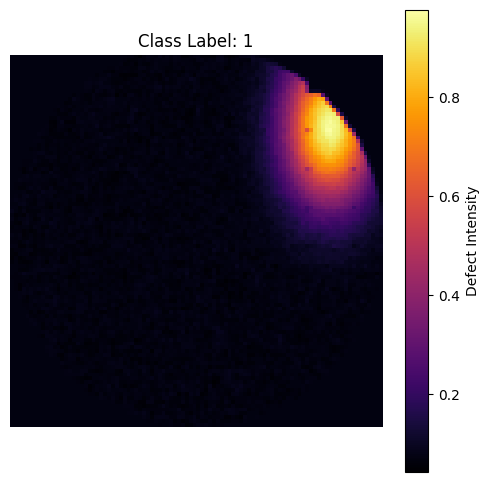

In [23]:
# 학습 데이터셋 이미지를 시각화합니다.
show_wafermap(train_dataset, 41)

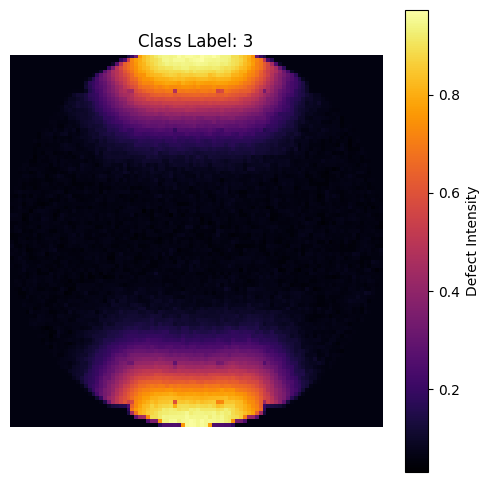

In [24]:
# 테스트 이미지를 시각화합니다.
show_wafermap(test_dataset, 93)

>예시코드

```
# 학습 데이터셋 이미지를 시각화합니다.
show_wafermap(train_dataset, 41)

# 테스트 이미지를 시각화합니다.
show_wafermap(test_dataset, 93)
```

### 3.2 데이터로더 생성

데이터셋을 바탕으로 데이터로더를 생성합니다.

데이터로더에는 배치의 크기를 입력하여 데이터를 해당 크기만큼 분할하는 기능을 제공합니다.

또 `shuffle` 메서드를 통해 학습 시 배치를 무작위로 모델에 입력할지, 순서를 지켜 입력할 지 선택할 수 있는 옵션도 제공합니다.

In [25]:
# 배치 사이즈를 설정합니다.
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### [TODO] 테스트 데이터 로더를 생성해주세요.

학습 데이터로더와 동일한 배치 사이즈를 가지며, 데이터를 섞지 않도록 옵션을 주세요.

In [26]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

> 예시코드

```
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
```

데이터로더는 `len()`함수가 적용됩니다. 데이터로더 내 전체 몇 개의 배치가 존재하는 지 확인할 수 있습니다.

In [27]:
len(train_loader)

25

학습 데이터로더는 25개의 배치로 구성되는 것이 확인됩니다.

배치의 수는 전체 데이터를 배치 크기로 나눈 값과 같기 때문이죠.

In [28]:
train_dataset.__len__() // batch_size

25

마찬가지 방식으로 테스트 데이터로더의 크기도 확인할 수 있습니다.

In [29]:
len(test_loader)

7

## 4. 모델 학습 및 평가

데이터로더가 준비되었으므로, 모델의 클래스를 선언하겠습니다.

아래의 순서에 맞게 모델 클래스를 만들도록 하겠습니다.

- CNN 모델 클래스 정의
```
class CNNClassifier(nn.Module):
```

- 생성자 함수 정의

    - `__init__`메서드 내에서 모델의 레이어를 정의합니다.

    - `super()` 함수를 사용하여 부모 클래스의 생성자를 호출합니다.

    - `num_classes`: 최종 출력 클래스의 수

```
def __init__(self, num_classes=5):
    super(CNNClassifier, self).__init__()
```

- 첫 번째 컨볼루션 레이어 추가

    - 입력 채널: 1, 출력 채널: 16, 커널 크기: 13x13

    - Stride: 1, 패딩은 추가하지 않습니다.

```
self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=13, stride=1, padding=0)
```

- 풀링 레이어 추가

    - 커널 크기: 2x2

```
self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
```

- 두 번째 컨볼루션 레이어 추가

    - 입력 채널: 16, 출력 채널: 32, 커널 크기: 9x9

```
self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=9, stride=1, padding=0)
```

- FCL(Fully Connected Layer) 추가

    - 첫 번째 완전 연결 레이어: 입력 크기: 32 * 17 * 17, 출력 크기: 128

    - 두 번째 완전 연결 레이어: 입력 크기: 128, 출력 크기: `num_classes`

```
self.fc1 = nn.Linear(32 * 17 * 17, 128)
self.fc2 = nn.Linear(128, num_classes)
```

### [TODO] 모델의 `forward` 메서드를 완성해주세요.

아래 지시사항을 따라 만들어보세요.

1. 첫 번째 컨볼루션 레이어 적용: 입력 x를 conv1라는 컨볼루션 레이어를 통해 전달하세요.

2. ReLU 활성화 함수 적용: 방금 전달한 출력에 ReLU 활성화 함수를 적용하세요.

    - `F.relu()` 

3. 풀링 레이어 적용: ReLU 활성화 함수를 통과한 결과를 pool이라는 풀링 레이어를 통해 전달하세요.

4. 두 번째 컨볼루션 레이어 적용: 풀링 레이어를 통과한 결과를 conv2라는 두 번째 컨볼루션 레이어에 전달하세요.

5. ReLU 활성화 함수 적용: 두 번째 컨볼루션 레이어를 통과한 결과에 다시 ReLU 활성화 함수를 적용하세요.

6. 풀링 레이어 적용: ReLU 활성화 함수를 통과한 결과를 다시 pool이라는 풀링 레이어에 전달하세요.

7. 텐서 재구성: 풀링 레이어를 통과한 결과의 형태를 변경하세요. 이때, -1을 첫 번째 차원으로 사용하고, 나머지 차원은 32 * 17 * 17로 설정하세요.

8. 첫 번째 FCL 적용: 재구성된 텐서를 fc1라는 FCL에 전달하고, 그 결과에 ReLU 활성화 함수를 적용하세요.

9. 두 번째 FCL 적용: 첫 번째 FCL를 통과한 결과를 fc2라는 두 번째 FCL에 전달하세요.

10. 결과 반환: Softmax 함수 적용 후 최종 결과를 반환하세요.
    
    - `F.softmax(dim=1)`

In [ ]:
def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool(x)
    
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool(x)
    
    x = x.view(-1, 32 * 17 * 17)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = F.softmax(x, dim=1)
            
    return x

> 예시코드
```
def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool(x)
    
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool(x)
    
    x = x.view(-1, 32 * 17 * 17)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = F.softmax(x, dim=1)

    return x
```

### 4.1 모델 클래스 선언

### [TODO] 모델 클래스를 선언해주세요.

위에서 선언한 함수들을 바탕으로 모델 클래스를 선언해주세요.

In [30]:
# 끝에 ?를 붙이면 어떤 인자를 사용해야 하는지 설명이 나온다
nn.Conv2d?

In [40]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super(CNNClassifier, self).__init__()
        
        # model에서 사용할 모든 layer를 init에서 정의한다!
        
        # 첫 번째 컨볼루션 레이어
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=13, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # 두 번째 컨볼루션 레이어
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=9, stride=1, padding=0)
        
        # FCL
        self.fc1 = nn.Linear(32 * 17 * 17, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 32 * 17 * 17) # 1D로 데이터를 펴는 것
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        
        return x

모델 클래스 선언이 다 되었다면, 모델 출력층 형성을 위해 클래스의 수를 변수에 할당해봅시다.

In [39]:
# 위의 fully connected layer1번에서 32*17*17 이 된 원인을 알려면 각 레이어를 지나면서 데이터의 shape이 어떻게 변하는지를 알아야 하는데
# 일일히 계산하기 보다는 아래처럼 그냥 데이터를 통과시켜서 최종 크기를 알아내면 된다.
conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=13, stride=1, padding=0)
pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=9, stride=1, padding=0)


x = train_dataset[0][0]
print(x.size())
x = conv1(x)
print(x.size())
x = pool(x)
print(x.size())
x = conv2(x)
print(x.size())
x = pool(x)
print(x.size())

torch.Size([1, 96, 96])
torch.Size([16, 84, 84])
torch.Size([16, 42, 42])
torch.Size([32, 34, 34])
torch.Size([32, 17, 17])


In [41]:
num_classes = len(defect_features)
print(num_classes)

5


### [TODO] 모델 인스턴스를 생성하고, 구조를 출력해주세요.

`print()`메서드를 사용하면 모델의 구조를 확인할 수 있습니다.

In [42]:
# 모델 인스턴스화
model = CNNClassifier(num_classes=num_classes)
print(model)

CNNClassifier(
  (conv1): Conv2d(1, 16, kernel_size=(13, 13), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(9, 9), stride=(1, 1))
  (fc1): Linear(in_features=9248, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)


### 4.2. 훈련 함수 선언

훈련과정을 루프로 만든 함수를 선언합니다. 다음 절차에 따라 동작됩니다.

- 모델 장치 설정: 주어진 장치(device)로 모델을 이동시킵니다. 이는 GPU나 CPU에서 학습을 진행하기 위함입니다.

- 에폭 반복: 지정된 에폭 수(num_epochs)만큼 학습을 반복합니다.

- 모델 학습 모드 설정: 모델을 학습 모드로 설정합니다. 이렇게 설정하면, 예를 들어, BatchNorm이나 Dropout과 같은 레이어들이 학습 모드에 맞게 동작하게 됩니다.

- 배치 데이터 처리: 학습 데이터 로더(train_loader)에서 배치 단위로 데이터를 가져와 학습을 진행합니다.

- 그래디언트 초기화: 이전 그래디언트 값을 초기화합니다.

- 예측 계산: 현재 모델을 사용하여 배치 데이터의 예측값을 계산합니다.

- 손실 계산: 예측값과 실제 레이블 간의 손실을 계산합니다.

- 그래디언트 계산: 손실에 대한 그래디언트를 계산합니다.

- 모델 업데이트: 계산된 그래디언트를 사용하여 모델의 파라미터를 업데이트합니다.

- 통계 정보 업데이트: 현재 배치의 손실과 정확도 정보를 업데이트합니다.

- 에폭별 출력: 각 에폭마다 평균 손실과 학습 정확도를 출력합니다.


### [TODO] 훈련함수의 코드를 완성해주세요.

위의 절차에 맞게 함수의 빈칸을 완성해주세요. 헷갈린다면 주석을 참조해주세요.

In [43]:
def train_model(model, train_loader, optimizer, criterion, num_epochs=10, device='cuda'):
    """
    PyTorch를 사용하여 CNN 모델 학습

    Parameters:
    - model: 학습할 모델
    - train_loader: 학습 데이터 로더
    - val_loader: 검증 데이터 로더
    - optimizer: 최적화 알고리즘
    - criterion: 손실 함수
    - num_epochs: 학습 에폭 수
    - device: 학습 장치 ('cuda' 또는 'cpu')
    """
    
    # 모델을 지정된 장치로 이동
    model.to(device)
    
    # 에폭 수만큼 학습을 반복
    for epoch in range(num_epochs):
        model.train()  # 모델을 학습 모드로 설정. 이는 BatchNorm, Dropout 등의 레이어에 영향을 줍니다.
        
        total_loss = 0.0  # 전체 손실을 저장하기 위한 변수 초기화
        correct = 0  # 올바르게 예측된 샘플 수를 저장하기 위한 변수 초기화
        total = 0  # 전체 샘플 수를 저장하기 위한 변수 초기화
        
        # 학습 데이터 로더에서 배치 단위로 데이터를 가져와 학습
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 지정된 장치로 이동
            
            optimizer.zero_grad()  # 이전 그래디언트를 초기화하여 새로운 최적화 단계를 시작
            
            outputs = model(inputs)  # 모델을 통해 입력 데이터의 예측값 계산
            loss = criterion(outputs, labels)  # 예측값과 실제 레이블 간의 손실 계산
            loss.backward()  # 손실에 대한 그래디언트 계산
            optimizer.step()  # 그래디언트를 사용하여 모델의 파라미터 업데이트
            
            total_loss += loss.item() * inputs.size(0)  # 배치의 손실을 전체 손실에 더함
            
            _, predicted = outputs.max(1)  # 예측값에서 가장 높은 확률을 가진 클래스 선택
            total += labels.size(0)  # 배치의 샘플 수를 전체 샘플 수에 더함
            correct += (predicted == labels).sum().item()  # 올바르게 예측된 샘플 수를 저장
        
        avg_train_loss = total_loss / total  # 평균 손실 계산
        train_accuracy = correct / total  # 학습 정확도 계산
        
        # 에폭마다 평균 손실과 학습 정확도 출력
        print(f"Epoch [{epoch + 1}/{num_epochs}] - "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}")
    
    return model

> 예시코드

```
def train_model(model, train_loader, optimizer, criterion, num_epochs=10, device='cuda'):
    """
    PyTorch를 사용하여 CNN 모델 학습

    Parameters:
    - model: 학습할 모델
    - train_loader: 학습 데이터 로더
    - val_loader: 검증 데이터 로더
    - optimizer: 최적화 알고리즘
    - criterion: 손실 함수
    - num_epochs: 학습 에폭 수
    - device: 학습 장치 ('cuda' 또는 'cpu')
    """
    
    # 모델을 지정된 장치로 이동
    model.to(device)
    
    # 에폭 수만큼 학습을 반복
    for epoch in range(num_epochs):
        model.train()  # 모델을 학습 모드로 설정. 이는 BatchNorm, Dropout 등의 레이어에 영향을 줍니다.
        
        total_loss = 0.0  # 전체 손실을 저장하기 위한 변수 초기화
        correct = 0  # 올바르게 예측된 샘플 수를 저장하기 위한 변수 초기화
        total = 0  # 전체 샘플 수를 저장하기 위한 변수 초기화
        
        # 학습 데이터 로더에서 배치 단위로 데이터를 가져와 학습
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 지정된 장치로 이동
            
            optimizer.zero_grad()  # 이전 그래디언트를 초기화하여 새로운 최적화 단계를 시작
            
            outputs = model(inputs)  # 모델을 통해 입력 데이터의 예측값 계산
            loss = criterion(outputs, labels)  # 예측값과 실제 레이블 간의 손실 계산
            loss.backward()  # 손실에 대한 그래디언트 계산
            optimizer.step()  # 그래디언트를 사용하여 모델의 파라미터 업데이트
            
            total_loss += loss.item() * inputs.size(0)  # 배치의 손실을 전체 손실에 더함
            
            _, predicted = outputs.max(1)  # 예측값에서 가장 높은 확률을 가진 클래스 선택
            total += labels.size(0)  # 배치의 샘플 수를 전체 샘플 수에 더함
            correct += (predicted == labels).sum().item()  # 올바르게 예측된 샘플 수를 저장
        
        avg_train_loss = total_loss / total  # 평균 손실 계산
        train_accuracy = correct / total  # 학습 정확도 계산
        
        # 에폭마다 평균 손실과 학습 정확도 출력
        print(f"Epoch [{epoch + 1}/{num_epochs}] - "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}")
    
    return model
```

모델 학습에 필요한 손실함수와 옵티마이저를 불러옵니다.

옵티마이저는 SGD(Stochastic Gradient Descent), 손실함수는 Cross entropy를 사용하겠습니다.

학습 횟수는 10회로 설정하겠습니다.

In [ ]:
# 옵티마이저와 손실 함수 설정
optimizer = optim.SGD(model.parameters(), lr=1e-4)

criterion = nn.CrossEntropyLoss()

epochs = 10

### 4.3 모델 훈련

훈련을 위한 준비가 끝났습니다. 모델을 훈련시켜보도록 합시다.

### [TODO] 모델 학습 함수를 사용하여 모델을 훈련시켜주세요.

학습함수에 필요한 인자들을 불러와 모델의 학습시킵니다. 

함수의 반환값이 모델이므로, 결과를 `trained_model` 변수에 저장해주세요.

In [ ]:
trained_model = train_model(model, 
            train_loader, 
            optimizer, 
            criterion,
            num_epochs = epochs,
            device=device)

> 예시코드

```
trained_model = train_model(model, 
            train_loader, 
            optimizer, 
            criterion,
            num_epochs = epochs,
            device=device)
```

좋은 소식과 나쁜 소식이 모두 보입니다.

좋은 점은, 모델이 아무 오류 없이 동작했다는 점이고, 나쁜 점은 모델의 성능이 형편없다는 것입니다.

이 부분은 뒤에 추가적인 모델 구조를 개선하여 재학습시킬 때 성능을 올려보도록 하겠습니다.

### 4.4 모델 평가

이번엔 완성된 모델을 테스트 데이터로 평가해보겠습니다.

우선 평가함수를 선언하겠습니다.

In [ ]:
def test_model(model, test_loader, criterion, device='cuda'):
    """
    PyTorch를 사용하여 CNN 모델 평가

    Parameters:
    - model: 평가할 모델
    - test_loader: 테스트 데이터 로더
    - criterion: 손실 함수
    - device: 평가 장치 ('cuda' 또는 'cpu')
    """
    
    # 모델을 평가 모드로 설정. 이는 BatchNorm, Dropout 등의 레이어에 영향을 줍니다.
    model.eval()
    
    # 모델을 지정된 장치로 이동
    model.to(device)
    
    # 전체 손실과 정확도를 계산하기 위한 변수 초기화
    total_loss = 0.0
    correct = 0
    total = 0
    
    # 그래디언트 계산 비활성화 (평가 중에는 필요 없음)
    with torch.no_grad():
        # 테스트 데이터 로더에서 배치 단위로 데이터를 가져와 평가
        for inputs, labels in test_loader:
            # 데이터를 지정된 장치로 이동
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 모델을 통해 입력 데이터의 예측값 계산
            outputs = model(inputs)
            # 예측값과 실제 레이블 간의 손실 계산
            loss = criterion(outputs, labels)
            
            # 배치의 손실을 전체 손실에 더함
            total_loss += loss.item() * inputs.size(0)
            
            # 예측값에서 가장 높은 확률을 가진 클래스 선택
            _, predicted = outputs.max(1)
            # 배치의 샘플 수를 전체 샘플 수에 더함
            total += labels.size(0)
            # 올바르게 예측된 샘플 수를 저장
            correct += (predicted == labels).sum().item()
    
    # 평균 테스트 손실과 테스트 정확도 계산
    avg_test_loss = total_loss / total
    test_accuracy = correct / total
    
    # 평균 테스트 손실과 테스트 정확도 출력
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    return avg_test_loss, test_accuracy

### [TODO] 선언된 평가함수를 이용하여 모델의 성능을 평가해주세요.

함수의 요구 인자들을 불러와 진행하시고, 반환형식에 맞게 결과를 `test_loss`, `test_accuracy` 변수에 담아 출력해주세요.

In [ ]:
test_loss, test_accuracy = test_model(trained_model, 
                                      test_loader, 
                                      criterion, device=device)

print(f"Test loss: {test_loss} | Test Accuracy: {test_accuracy}")

> 예시코드
```
test_loss, test_accuracy = test_model(trained_model, 
                                      test_loader, 
                                      criterion, device=device)

print(f"Test loss: {test_loss} | Test Accuracy: {test_accuracy}")                  
```

## 5.모델 개선

위에서 훈련시킨 모델의 성능이 마음에 들지 않습니다.

이번엔 모델에 다양한 기능을 추가하여 개선하고, 이에 대한 결과를 살펴보도록 하겠습니다.

모델에는 패딩 기능과 배치 정규화(Batch Normalization)을 추가해보도록 하겠습니다.

- 패딩: 컨볼루션 레이어에 패딩을 추가하여 입력과 출력의 공간적 크기(spatial size)를 유지하게 할 수 있습니다.

- 배치 정규화: 각 컨볼루션 레이어 후에 배치 정규화를 추가하여 학습을 안정화하고 속도를 향상시킬 수 있습니다.

### [TODO] 아래 설명을 바탕으로 모델을 개선해봅시다. 개선된 모델의 클래스 이름은 `CNNClassifier_v2`로 명명하겠습니다.

1. 패딩 추가하기:
    
    - nn.Conv2d에서 padding 매개변수를 사용하여 패딩을 추가합니다.

    - 패딩의 크기는 (kernel_size - 1) / 2로 설정하면 입력과 출력의 크기가 동일하게 유지됩니다. (단, kernel_size가 홀수일 때)

2. 배치 정규화 추가하기:

    - `__init__()` 메서드에 nn.BatchNorm2d()를 추가합니다.

    - nn.BatchNorm2d의 매개변수로는 해당 레이어의 출력 채널 수를 지정해야 합니다.

    - `forward` 메서드에서, 각 컨볼루션 레이어 후에 nn.BatchNorm2d를 사용하여 배치 정규화 레이어를 추가합니다.

    - 배치정규화는 컨볼루션 이후, 활성화 함수 적용 전에 사용합니다.

3. FCL 레이어의 입력 값을 변경합니다.

    - 패딩과 풀링을 적용한 후의 텐서 크기를 정확하게 계산해야 합니다.

    - 변경된 크기를 view 및 nn.Linear에 적용해야 합니다.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class CNNClassifier_v2(nn.Module):
    def __init__(self, num_classes=5):
        super(CNNClassifier_v2, self).__init__()

        # 첫 번째 컨볼루션 레이어
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=16, kernel_size=13, stride=1, padding=6
        )  # 패딩 추가
        self.bn1 = nn.BatchNorm2d(16)  # 배치 정규화 추가
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # 두 번째 컨볼루션 레이어
        self.conv2 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=9, stride=1, padding=4
        )  # 패딩 추가
        self.bn2 = nn.BatchNorm2d(32)  # 배치 정규화 추가

        # FCL
        self.fc1 = nn.Linear(32 * 24 * 24, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # 배치 정규화 적용
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)  # 배치 정규화 적용
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(-1, 32 * 24 * 24)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)

        return x

> 예시코드
```
import torch.nn as nn
import torch.nn.functional as F


class CNNClassifier_v2(nn.Module):
    def __init__(self, num_classes=5):
        super(CNNClassifier_v2, self).__init__()

        # 첫 번째 컨볼루션 레이어
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=16, kernel_size=13, stride=1, padding=6
        )  # 패딩 추가
        self.bn1 = nn.BatchNorm2d(16)  # 배치 정규화 추가
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # 두 번째 컨볼루션 레이어
        self.conv2 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=9, stride=1, padding=4
        )  # 패딩 추가
        self.bn2 = nn.BatchNorm2d(32)  # 배치 정규화 추가

        # FCL
        self.fc1 = nn.Linear(32 * 24 * 24, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # 배치 정규화 적용
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)  # 배치 정규화 적용
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(-1, 32 * 24 * 24)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)

        return x
```

In [ ]:
# 모델 인스턴스화
model_v2 = CNNClassifier_v2(num_classes=num_classes)
print(model)

모델 학습에 필요한 옵티마이저와 손실함수도 설정해봅시다.

In [ ]:
# 옵티마이저와 손실 함수 설정
optimizer = optim.SGD(model_v2.parameters(), lr=1e-4)

criterion = nn.CrossEntropyLoss()

epochs = 10

In [ ]:
trained_model_v2 = train_model(model_v2, 
            train_loader, 
            optimizer, 
            criterion,
            num_epochs = epochs,
            device=device)

어떤가요? 모델의 성능이 많이 개선되었음을 확인할 수 있습니다. 

테스트 데이터를 바탕으로 모델을 평가해볼까요?

### [TODO] 선언된 평가함수를 이용하여 모델의 성능을 평가해주세요.

함수의 요구 인자들을 불러와 진행하시고, 반환형식에 맞게 결과를 `test_loss_v2`, `test_accuracy_v2` 변수에 담아 출력해주세요.

In [ ]:
test_loss_v2, test_accuracy_v2 = test_model(trained_model_v2, 
                                      test_loader, 
                                      criterion, device=device)

print(f"Test loss: {test_loss_v2} | Test Accuracy: {test_accuracy_v2}")

훌륭합니다! 모델의 성능이 많이 개선된 것을 확인할 수 있습니다.

그러나 아직 안심하기엔 이릅니다. 우리가 훈련한 모델은 800여 개의 데이터만 활용하여 학습을 시켰기에 과적합의 우려가 있고, 일반화 성능이 모자랄 수도 있습니다.

추가적인 실습 과정에서, 모델의 구성요소를 변경하거나 하이퍼파라미터를 조정하여 성능을 높이려는 시도를 추가해보시길 바랍니다.

다음 시간엔 모델의 성능을 높이기 위한 다양한 방법과 모델의 학습 도중 지표를 모니터링하는 방법을 연습하도록 하겠습니다.

수고하셨습니다!